In [1]:
import cv2
import imutils
import numpy as np
from pathlib import Path
from natsort import natsorted
import time
import multiprocessing.pool
import pandas as pd

import matplotlib.pyplot as plt

# Functions

In [2]:
def resize(frame, maxHeight=500, maxWidth=1500):
    # If resize factor for height is greater than that of width
    if frame.shape[0]/maxHeight > frame.shape[1]/maxWidth:
        resizedFrame = imutils.resize(frame.copy(), height=maxHeight)
    else:
        resizedFrame = imutils.resize(frame.copy(), width=maxWidth)
    return resizedFrame, resizedFrame.shape[0]/frame.shape[0]

def getROIFromVideo(vidPath, fromCenter=False):
    vs = cv2.VideoCapture(vidPath)
    
    ret, frame = vs.read()

    # while ret:
    #     ret, frame = vs.read()
    #     dispFrame, _ = resize(frame)
    #     cv2.imshow("Video", dispFrame)
    #     key = cv2.waitKey(0)
    #     if key == ord('q') or key == 27:
    #         break

    return getROIFromFrame(frame)

def getROIFromFrame(frame, fromCenter=False):
    frame, scale = resize(frame)
    r = cv2.selectROI(frame, fromCenter=fromCenter)
    cv2.destroyAllWindows()

    # If ROI invalid, return whole image
    if len(np.unique(r)) < 4:
        r = np.zeros(4).astype("int")
        r[3] = len(frame)
        r[2] = len(frame[0])
    
    return np.round(np.array(r)/scale).astype("int")

def cropWithROI(frame, roi):
    return frame[int(roi[1]):int(roi[1]+roi[3]), int(roi[0]):int(roi[0]+roi[2])]

def getTemplatesFromVideo(vidPath, pipeline, templateWidth, templateHeight):
    box = None
    templates = []

    def on_mouse(event, x, y, flags, userdata):
        nonlocal box
        # Draw box
        if event == cv2.EVENT_LBUTTONDOWN:
            p = (x,y)
            p1 = (int(p[0]-templateWidth/2), int(p[1]-templateHeight/2))
            p2 = (int(p[0]+templateWidth/2), int(p[1]+templateHeight/2))
            box = [p1[0], p1[1], templateWidth, templateHeight]

            frameDraw = frame.copy()
            cv2.rectangle(frameDraw, p1, p2, (255, 0, 0), 1)
            cv2.imshow('Frame', frameDraw)

    cap = cv2.VideoCapture(vidPath)
    cv2.namedWindow('Frame', cv2.WINDOW_AUTOSIZE)
    cv2.setMouseCallback('Frame', on_mouse)

    while cap.isOpened():
        _, frame = cap.read()
        frame = pipeline(frame)
        
        cv2.imshow("Frame", frame)
        key = cv2.waitKey(0)
        if key == ord("q") or key == ord("Q"):
            cap.release()
            cv2.destroyAllWindows()

        if key == ord("e") or key == ord("E"):
            if box is not None:
                templates.append(cropWithROI(frame, box))

    return templates

class SelectionWindow():

    def __init__(self, title, frame):
        self.title = title
        self.frame = frame.copy()
        
        self.minPointsLeft = 0
        self.func = self.callback_func

        self.selectionPts = []
       
    def displayWindow(self):
        cv2.namedWindow(self.title)
        if self.func != None:
            cv2.setMouseCallback(self.title, self.func)
        cv2.imshow(self.title, self.frame)
        
        while True:
            key = cv2.waitKey(0)
            
            if self.minPointsLeft <= 0 and key == 27:
                cv2.destroyWindow(self.title) 
                break

    def callback_func(self,event,x,y,flags,param):
        if event == cv2.EVENT_LBUTTONDOWN or event == cv2.EVENT_RBUTTONDOWN:
            self.minPointsLeft -= 1
            self.selectionPts.append((x, y))
            cv2.circle(self.frame, (x,y), 2, (255,255,255), thickness=1)
            cv2.imshow(self.title, self.frame)

class CalibWindow(SelectionWindow):

    def __init__(self, title, frame):
        super().__init__(title, frame)
        self.calibPoints = []
        self.minPointsLeft = 2
        self.func = self.set_calib_length

    def set_calib_length(self,event,x,y,flags,param):
        if event == cv2.EVENT_LBUTTONDOWN or event == cv2.EVENT_RBUTTONDOWN:
            self.minPointsLeft -= 1
            self.calibPoints.append((x, y))
            cv2.circle(self.frame, (x,y), 2, (255,255,255), thickness=1)
            cv2.imshow(self.title, self.frame)
    
    def getCalibScale(self, calibLength):
        p1 = self.calibPoints[-1]
        p2 = self.calibPoints[-2]
        return ((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)**0.5/calibLength

# Crop Video

In [3]:
vidPath = "ball1.MP4"
crop_roi = getROIFromVideo(vidPath)
cv2.destroyAllWindows()

# Perspective

In [5]:
vidPath = "ball1.MP4"
vs = cv2.VideoCapture(vidPath)
ret, frame = vs.read()
frame = cropWithROI(frame, crop_roi)

perspectiveWindow = SelectionWindow("Perspective", frame)
perspectiveWindow.displayWindow()

In [6]:
perspectiveWindow.selectionPts

[(22, 13), (225, 15), (245, 671), (8, 675)]

In [7]:
objLength = 1.83
objWidth = 0.6
imgWidth = 200
imgHeight = round(objLength/objWidth*imgWidth)

srcPts = np.float32(perspectiveWindow.selectionPts)
dstPts = np.float32([(0, 0), (imgWidth, 0), (imgWidth, imgHeight), (0, imgHeight)])
M = cv2.getPerspectiveTransform(srcPts, dstPts)
dst = cv2.warpPerspective(frame, M, (imgWidth,imgHeight))
cv2.imshow("Transformed", dst)
cv2.waitKey(0)
cv2.destroyAllWindows()

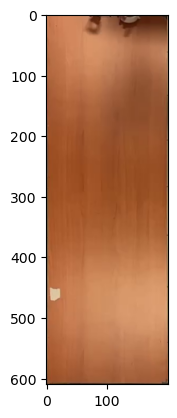

In [8]:
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

# Get Template(s)

In [9]:
pipeline = lambda frame: cv2.warpPerspective(cropWithROI(frame, crop_roi), M, (imgWidth, imgHeight))
templates = getTemplatesFromVideo(vidPath, pipeline, templateWidth=10, templateHeight=10)

## Save Template(s)

In [10]:
templatesDir = Path("templates_ball")
imgPaths = natsorted([str(path) for path in templatesDir.glob("*.jpg")])

if imgPaths:
    latestImgN = int(Path(imgPaths[-1]).stem)+1
else:
    latestImgN = 0
    
for i in range(len(templates)):
    cv2.imwrite(str(templatesDir/f"{latestImgN+i}.jpg"), templates[i])

templates.clear()


## Load Template(s)

In [11]:
templatesDir = Path("templates_ball")
imgPaths = templatesDir.glob("*.jpg")

templates = []
for imgPath in imgPaths:
    template = cv2.imread(str(imgPath))
    templates.append(template)
    cv2.imshow("Template", template)
    cv2.waitKey(0)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [12]:
def getTemplateMatches(frame, template, confidenceThresh):
    res = cv2.matchTemplate(frame, template, cv2.TM_CCOEFF_NORMED)
    loc = np.where(res >= confidenceThresh)

    confidences = res[loc]

    boxes = []
    w, h = template.shape[-2::-1]
    for pt in zip(*loc[::-1]):
        boxes.append([*pt, pt[0] + w, pt[1] + h])

    return boxes, confidences

def getOutputVidFrameSize(vidPath, pipeline, outputHeight):
    cap = cv2.VideoCapture(vidPath)
    _, frame = cap.read()
    frame = pipeline(frame)
    frame = imutils.resize(frame, height=outputHeight)
    return frame.shape[-2::-1]

In [13]:
VID_PATH = "ball1.MP4"
OUTPUT_VID_PATH = "output.MP4"
OUTPUT_HEIGHT = 800

NMS_THRESHOLD = 0.7
CONFIDENCE_THRESHOLD = 0.8

IMSHOW_FLAG = True
WRITE_FLAG = True

num_cpu = multiprocessing.cpu_count() - 1
pool = multiprocessing.pool.ThreadPool(processes=num_cpu)

cap = cv2.VideoCapture(VID_PATH)

totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
frameCount = 0
startTime = time.time()

frameWidth, frameHeight = getOutputVidFrameSize(VID_PATH, pipeline, OUTPUT_HEIGHT)
out = cv2.VideoWriter(OUTPUT_VID_PATH, cv2.VideoWriter_fourcc(*"mp4v"), cap.get(cv2.CAP_PROP_FPS), (frameWidth,frameHeight))
print(f"Output frame width: {frameWidth}, frame height: {frameHeight}")

saveFrames = []
saveBoxes = []

pipeline = lambda frame: cv2.warpPerspective(cropWithROI(frame, crop_roi), M, (imgWidth, imgHeight))

ret, frame = cap.read()
while ret: 
    if frameCount % 100 == 0 and frameCount != 0:
        elapsedTime = time.time()-startTime
        estTimeLeft = (totalFrames-frameCount)/frameCount*elapsedTime
        print(f"Frame {frameCount} out of {round(totalFrames)}.")
        print(f"\tTime taken: {round(elapsedTime)}s. Est. time left: {round(estTimeLeft)}s")

    img_rgb = pipeline(frame)

    # Multithreading
    mapIterable = []
    for i in range(len(templates)):
        template = templates[i]
        mapIterable.append((img_rgb, template, CONFIDENCE_THRESHOLD))
    results = pool.starmap(func=getTemplateMatches, iterable=mapIterable)

    boxes, confidences = [], []
    for result in results:
        boxes.extend(result[0])
        confidences.extend(result[1])

    # Serial
    # boxes, confidences = [], []
    # for template in templates:
    #     val = getTemplateMatches(img_rgb, template, CONFIDENCE_THRESHOLD)
    #     boxes.extend(val[0])
    #     confidences.extend(val[1])

    indices = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE_THRESHOLD, NMS_THRESHOLD)
    boxes = [boxes[idx] for idx in indices]
    confidences = [confidences[idx] for idx in indices]
    
    if boxes:
        saveFrames.append(frameCount)
        saveBoxes.append(boxes[0].copy())

    for box in boxes:
        cv2.rectangle(img_rgb, box[:2], box[2:], (0,0,255), 2)
    
    img_rgb = imutils.resize(img_rgb, height=OUTPUT_HEIGHT)

    if WRITE_FLAG:
        out.write(img_rgb)

    if IMSHOW_FLAG:
        cv2.imshow("Detections", img_rgb)
        key = cv2.waitKey(1)
        if key == ord('q') or key == ord('Q'):
            break
 
    ret, frame = cap.read()
    frameCount += 1

cv2.destroyAllWindows()
out.release()
cap.release()

Output frame width: 262, frame height: 800
Frame 100 out of 251.
	Time taken: 2s. Est. time left: 3s
Frame 200 out of 251.
	Time taken: 4s. Est. time left: 1s


In [14]:
# import pickle
# f = open("temp.pkl", "wb")
# pickle.dump([saveFrames, saveBoxes], f)

In [15]:
# import pickle
# f = open("temp.pkl", "rb")
# pickle.load(f)

# Scale Calibration

In [16]:
cap = cv2.VideoCapture(VID_PATH)
ret, frame = cap.read()

img_rgb = pipeline(frame)

# CalibWin = CalibWindow("Calibration", img_rgb)
# CalibWin.displayWindow()
# calibPoints = CalibWin.calibPoints
# calibLength = 0.60
# scale = CalibWin.getCalibScale(calibLength)
# key = cv2.waitKey(0)

scale = img_rgb.shape[1]/objWidth
scale

333.33333333333337

In [17]:
img_rgb.shape

(610, 200, 3)

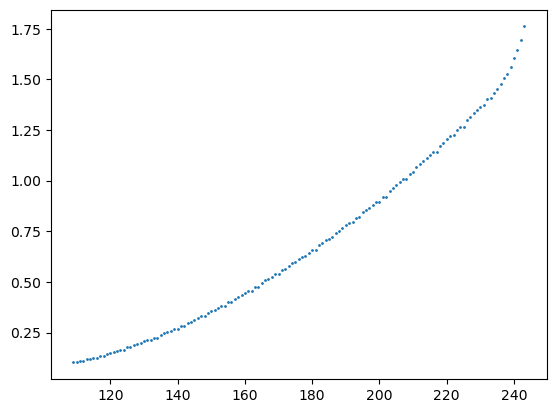

In [19]:
coords = np.array([[(b[0]+b[2])/2, (b[1]+b[3])/2] for b in saveBoxes])/scale
plt.scatter(saveFrames[::1], coords[:,1][::1], s=1)

In [23]:
coords[:,1].max() - coords[:,1].min()


1.6589999999999998

In [20]:
csvPath = Path(VID_PATH).stem + ".csv"
df = pd.DataFrame([saveFrames, coords[:,0], coords[:,1]]).T
df.to_csv(csvPath, index=None, header=["frame","x","y"])

In [21]:
cap = cv2.VideoCapture(VID_PATH)
h = int(cap.get(cv2.CAP_PROP_FOURCC))
codec = chr(h&0xff) + chr((h>>8)&0xff) + chr((h>>16)&0xff) + chr((h>>24)&0xff)
codec

cap.get(cv2.CAP_PROP_FPS)

30.0

Multithreading Time (1100 frames, 5 threads, 5 templates): 75s  
Serial Time (1100 frames, 5 templates): 193s

TODO: try with map_async

# Junk

In [ ]:
cap = cv2.VideoCapture("video.mov")
ret, frame = cap.read()
while ret:    
    ret, frame = cap.read()

    frame = frame[int(roi[1]):int(roi[1]+roi[3]), int(roi[0]):int(roi[0]+roi[2])]

    cv2.imshow("RGB", frame)

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    cv2.imshow("HSV", hsv)
    h,s,v = cv2.split(hsv)

    ret, th = cv2.threshold(v, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    cv2.imshow("OTSU", th)
    cv2.imshow("V", v)

    rows = v.shape[0]
    circles = cv2.HoughCircles(v, cv2.HOUGH_GRADIENT_ALT, 1, rows/128,
                               param1=500, param2=0.8,
                               minRadius=1, maxRadius=200)
    
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            center = (i[0], i[1])
            # circle center
            cv2.circle(frame, center, 1, (0, 100, 100), 1)
            # circle outline
            radius = i[2]
            cv2.circle(frame, center, radius, (255, 0, 255), 1)
    
    cv2.imshow("detected circles", frame)
    key = cv2.waitKey(0)

    if key == ord('q') or key == ord('Q'):
        break

cv2.destroyAllWindows()

In [ ]:
# img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
# template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
# res = cv2.matchTemplate(img_gray, template_gray, cv2.TM_CCOEFF_NORMED)

# img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2HSV)
# template_hsv = cv2.cvtColor(template, cv2.COLOR_BGR2HSV)
# _, _, img_v = cv2.split(img_hsv)
# _, _, template_v = cv2.split(template_hsv)
# res = cv2.matchTemplate(img_v, template_v, cv2.TM_CCOEFF_NORMED)